<a href="https://colab.research.google.com/github/2018007956/HYU/blob/main/Deep_Learning/06_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Tensor의 Gradient 계산방식
- Optimizers

#1. Tensor의 Gradient
gradient 계산: tensor.grad, loss.backward()  
Ex) a,b:data, Q:loss

In [1]:
import torch 

a = torch.tensor([2.], requires_grad=True)
b = torch.tensor([6.], requires_grad=True)

In [2]:
Q = 3*a**3-b**2
Q

tensor([-12.], grad_fn=<SubBackward0>)

Loss backward를 하면 tensor.grad로 각 텐서의 gradient값이 저장된다.  
-> torch.autograd라는 모듈이 해줌

In [3]:
print(a.grad)
print(b.grad)

None
None


In [4]:
Q.backward()

In [5]:
print(a.grad)
print(b.grad)

tensor([36.])
tensor([-12.])


## How does PyTorch optimizer work?
torch.autograd: PyTorch's automatic differentiation engine  
- logits = model(input) # Forward  
  Computational Graph 생성 (DAG), grad_fn 저장
- loss.backward() # Backward  
  Graph의 grad_fn으로 gradient 계산
  각 Tensor.grad에 gradient 저장
- optimizer.step()  
  각 Tensor.grad에 저장된 gradient와 learning rate로 Tensor값 update

#2. Optimizer

- Gradient Descent (GD)  
- Stochastic Gradient Descent (SGD)  
- Momentum  
- Adagrad (Adaptive Gradient)  
- RMSProp
- Adaptive Moment Estimation (Adam)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [9]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [10]:
import torchvision
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.CIFAR10(root='CIFAR10/',
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='CIFAR10/',
                                             train=False,
                                             transform=transforms.ToTensor(),
                                             download=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29029109.83it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


In [11]:
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [12]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.linear1 = nn.Linear(32*32*3, 256)
    self.linear2 = nn.Linear(256, 128)
    self.linear3 = nn.Linear(128, 10)

    self.activation = nn.Sigmoid()

  def forward(self, x):
    z1 = self.linear1(x)
    a1 = self.activation(z1)

    z2 = self.linear2(a1)
    a2 = self.activation(z2)

    z3 = self.linear3(a2)

    return z3

In [13]:
model = Model().to(device).train()

In [17]:
# optimizer = optim.SGD(params=model.parameters(), lr=1e-3) # GD
# optimizer = optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9) # Momentum
# optimizer = optim.Adagrad(params=model.parameters(), lr=1e-3) # Adagrad(Adaptive Gradient)
# optimizer = optim.RMSprop(params=model.parameters(), lr=1e-3, alpha=0.99) #RMSProp
optimizer = optim.Adam(params=model.parameters(), lr=1e-3, betas=(0.9, 0.999)) # Adaptive Moment Estimation (Adam)

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
epochs = 30
lmbd = 0.003

train_avg_costs = []
test_avg_costs = []

test_total_batch = len(test_dataloader)
total_batch_num = len(train_dataloader)

for epoch in range(epochs):
  avg_cost = 0
  model.train()
  for b_x, b_y in train_dataloader:
    b_x = b_x.view(-1, 32*32*3).to(device)
    logits = model(b_x) # forward propagation
    loss = criterion(logits, b_y.to(device)) # get cost

    # L2 Regularization
    reg = model.linear1.weight.pow(2.0).sum()
    reg += model.linear2.weight.pow(2.0).sum()
    reg += model.linear3.weight.pow(2.0).sum()
    loss += lmbd*reg/len(b_x)/2.

    optimizer.zero_grad()
    loss.backward() # backward propagation
    optimizer.step() # update parameters

    avg_cost += loss/total_batch_num
  train_avg_costs.append(avg_cost.detach().cpu())
  print('Epoch : {} / {}, cost: {}'.format(epoch+1, epochs, avg_cost))

  test_avg_cost=0
  model.eval()
  for b_x, b_y in test_dataloader:
    b_x = b_x.view(-1, 32*32*3).to(device)
    with torch.no_grad():
      logits = model(b_x)
      test_loss = criterion(logits, b_y.to(device)) # get cost 
    test_avg_cost += test_loss / test_total_batch 

  test_avg_costs.append(test_avg_cost.detach().cpu())

Epoch : 1 / 30, cost: 1.9528982639312744
Epoch : 2 / 30, cost: 1.7576435804367065
Epoch : 3 / 30, cost: 1.68436598777771
Epoch : 4 / 30, cost: 1.6232815980911255
Epoch : 5 / 30, cost: 1.5917290449142456
Epoch : 6 / 30, cost: 1.5540589094161987
Epoch : 7 / 30, cost: 1.5262577533721924
Epoch : 8 / 30, cost: 1.498754858970642
Epoch : 9 / 30, cost: 1.4849998950958252
Epoch : 10 / 30, cost: 1.4577566385269165
Epoch : 11 / 30, cost: 1.4443538188934326
Epoch : 12 / 30, cost: 1.4258406162261963
Epoch : 13 / 30, cost: 1.411635398864746
Epoch : 14 / 30, cost: 1.3957288265228271
Epoch : 15 / 30, cost: 1.3808066844940186
Epoch : 16 / 30, cost: 1.3722877502441406
Epoch : 17 / 30, cost: 1.355955719947815
Epoch : 18 / 30, cost: 1.343945860862732
Epoch : 19 / 30, cost: 1.3404145240783691
Epoch : 20 / 30, cost: 1.3259721994400024
Epoch : 21 / 30, cost: 1.31575345993042
Epoch : 22 / 30, cost: 1.3116672039031982
Epoch : 23 / 30, cost: 1.2986242771148682
Epoch : 24 / 30, cost: 1.2918165922164917
Epoch : 2

In [20]:
train_avg_costs = [a.cpu() for a in train_avg_costs]
test_avg_costs = [a.cpu() for a in test_avg_costs]

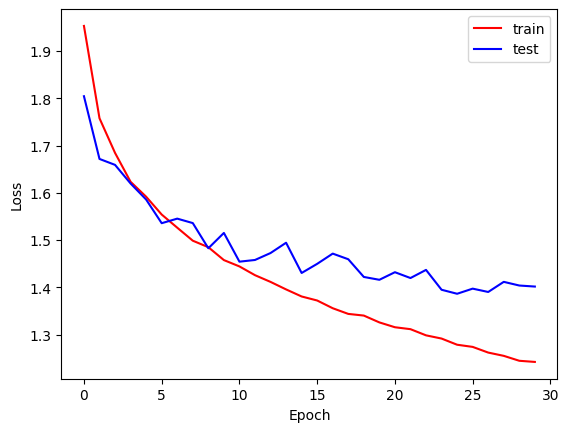

In [21]:
import matplotlib.pyplot as plt
import numpy as np
epoch = range(epochs)
plt.plot(epoch, train_avg_costs, 'r-')
plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'])
plt.show()

In [22]:
# Test set accuracy
from sklearn.metrics import accuracy_score

correct = 0
total = 0

model.eval()
for b_x, b_y in test_dataloader:
  b_x = b_x.view(-1, 32*32*3).to(device)
  
  with torch.no_grad():
    logits = model(b_x)
  probs = nn.Softmax(dim=1)(logits)
  
  predicts = torch.argmax(logits, dim=1)

  total += len(b_y)
  correct += (predicts == b_y.to(device)).sum().item()
  # -> accuracy_score(b_y, logits)랑 같은지 확인
  # total == len(test_dataloader) 맞는지 확인

print(f'Accuracy of the network on test images: {100 * correct / total} %')

Accuracy of the network on test images: 50.73 %
